In [1]:
import argparse
import tensorflow as tf
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

from tqdm import trange
from utils.config import Config
from model import ICNet, ICNet_BN

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Setup configurations

In [2]:
model_config = {'train': ICNet, 'trainval': ICNet, 'train_bn': ICNet_BN, 'trainval_bn': ICNet_BN, 'others': ICNet_BN}

# Choose dataset here, but remember to use `script/downlaod_weight.py` first
dataset = 'others'
filter_scale = 1
    
class InferenceConfig(Config):
    def __init__(self, dataset, is_training, filter_scale):
        Config.__init__(self, dataset, is_training, filter_scale)
    
    # You can choose different model here, see "model_config" dictionary. If you choose "others", 
    # it means that you use self-trained model, you need to change "filter_scale" to 2.
    model_type = 'others'

    # Set pre-trained weights here (You can download weight from Google Drive) 
#     model_weight = './model/cityscapes/icnet_cityscapes_trainval_90k.npy'
#     model_weight = './model/ade20k/model.ckpt-27150'
    model_weight = './snapshots/2/model.ckpt-6000'
    
    # Define default input size here
    INFER_SIZE = (480, 640, 3)
#     INFER_SIZE = (720, 1280, 3)
#     INFER_SIZE = (1080, 1920, 3)
                  
cfg = InferenceConfig(dataset, is_training=False, filter_scale=filter_scale)
cfg.display()

Setup configurations...

Configurations:
ADE20K_DATA_DIR                ./data/ADEChallengeData2016/
ADE20K_eval_list               ./data/list/ade20k_val_list.txt
ADE20K_train_list              ./data/list/ade20k_train_list.txt
BATCH_SIZE                     16
CITYSCAPES_DATA_DIR            ./data/cityscapes_dataset/cityscape/
CITYSCAPES_eval_list           ./data/list/cityscapes_val_list.txt
CITYSCAPES_train_list          ./data/list/cityscapes_train_list.txt
IMG_MEAN                       [103.939 116.779 123.68 ]
INFER_SIZE                     (480, 640, 3)
LAMBDA1                        0.16
LAMBDA2                        0.4
LAMBDA3                        1.0
LB_ADE20K_DATA_DIR             ./data/LB_ADE20K/
LEARNING_RATE                  0.0001
MOMENTUM                       0.9
N_WORKERS                      8
POWER                          0.9
RANDOM_SEED                    1234
SAVE_NUM_IMAGES                4
SAVE_PRED_EVERY                500
SNAPSHOT_DIR                   

# Create graph, session, and restore weights

In [3]:
# Create graph here 
model = model_config[cfg.model_type]
net = model(cfg=cfg, mode='inference')

# Create session & restore weight!
net.create_session()
net.restore(cfg.model_weight)






Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).




Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./snapshots/2/model.ckpt-6000
Restore from ./snapshots/2/model.ckpt-6000


# Run segmentation on single image

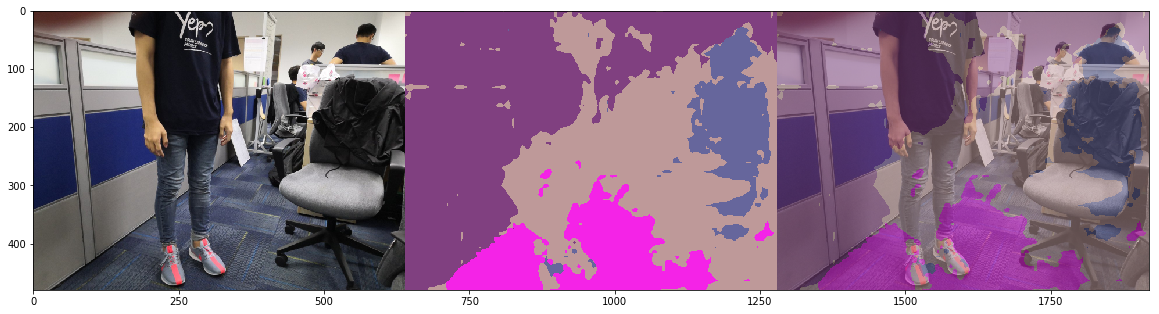

In [4]:
im1 = cv2.imread('./data/input/test02.jpeg')

if im1.shape != cfg.INFER_SIZE:
    im1 = cv2.resize(im1, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))
    
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

results1 = net.predict(im1)
overlap_results1 = 0.5 * im1 + 0.5 * results1[0]
vis_im1 = np.concatenate([im1/255.0, results1[0]/255.0, overlap_results1/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im1)

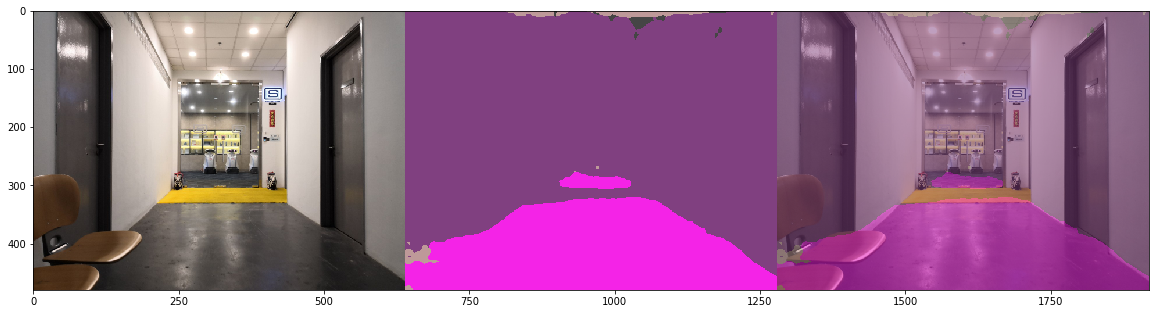

In [5]:
im2 = cv2.imread('./data/input/test03.jpeg')

if im2.shape != cfg.INFER_SIZE:
    im2 = cv2.resize(im2, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))
    
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
results2 = net.predict(im2)
overlap_results2 = 0.5 * im2 + 0.5 * results2[0]

vis_im2 = np.concatenate([im2/255.0, results2[0]/255.0, overlap_results2/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im2)

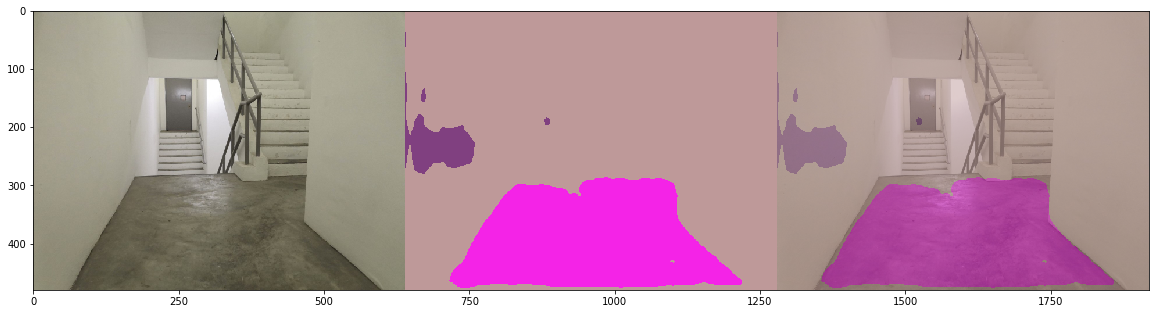

In [6]:
im2 = cv2.imread('./data/input/test04.jpeg')

if im2.shape != cfg.INFER_SIZE:
    im2 = cv2.resize(im2, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))
    
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
results2 = net.predict(im2)
overlap_results2 = 0.5 * im2 + 0.5 * results2[0]

vis_im2 = np.concatenate([im2/255.0, results2[0]/255.0, overlap_results2/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im2)

# Test inference speed

In [7]:
elapsed_times = []

for i in range(50):
    start_t = time.time()
    
    _ = net.predict(im1)
    
    duration = time.time() - start_t
    
    if i > 0:
        elapsed_times.append(duration)

print('Average time: {:.4f}, about {:.6f} fps'.format(np.mean(elapsed_times), 1/np.mean(elapsed_times)))

Average time: 0.0139, about 72.024422 fps
